# Classificação Supervisionada de Imagen de satélite com Random Forest

__Autoria:__ Sabrina Paes Leme P. Correa (paeslemesa@gmail.com) <br>
__Criação:__ 29/04/2024 <br>
__Modificação:__ 29/04/2024

__Descrição:__ Este tutorial vai mostrar passo-a-passo como classificar uma imagem de satélite a partir de amostras de treinamento já criadas. Se você tem dúvida de como criar amostras de treinamento a partir de shapefiles, siga este tutorial: [05_Transformar_Shapes_em_Amosrtas_ML](https://github.com/paeslemesa/tutoriaisPython/blob/main/05_Transformar_Shapes_em_Amosrtas_ML.ipynb).

Nós vamos dividir esse tutorial em partes ass
1. Importanto e ajustando os dados de treinamento
2. Treinando o modelo Random Forest e salvando o modelo
3. Validando o modelo
4. Classificando uma cena inteira do MSI/Sentinel-2

__Referências:__ 
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* https://scikit-learn.org/stable/model_persistence.html
* https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

## 1. Importanto bibliotecas e dados de treinamento

Para este tutorial, usaremos mais afundo as bibliotecas <code>rasterio</code> e <code>sklearn</code>.

Vamos usar também o arquivo CSV que está disponível do GitHub desse tutorial: https://raw.githubusercontent.com/paeslemesa/tutoriaisPython/main/amostras_aoi.csv<br>
Estamos trabalhando com quatro classes de uma imagem do sensor MSI/Sentinel-2 e bom as bandas RGB + NIR.<br>
As classes são:
1. Floresta
2. Agua
3. Pastagem
4. Solo Exposto

In [30]:
from pathlib import Path # para manipulação de arquivos
import joblib # para salvar e carregar modelos treinados

import numpy as np # para manipulação de arrays

import pandas as pd # para manipulação de dataframes


# Vamos nos basear nestas três bibliotecas para alguns gráficos
import matplotlib.pyplot as plt # para plotar gráficos
import seaborn as sns # para plotar gráficos

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


from tqdm.auto import tqdm # para barra de progresso

import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.merge import merge
from rasterio.plot import show

In [2]:
diretorio = Path("./")

arquivo = Path(diretorio, "amostras_aoi.csv") 

### 1.1. Abrindo o dataset e ajustando

In [3]:
df = pd.read_csv(arquivo) # abrindo o arquivo CSV

df.head()

,classe,azul,verde,vermelho,nir,ndvi
0,1,0.1299,0.1471,0.1240,0.4419,0.561760
1,1,0.1282,0.1414,0.1225,0.4151,0.544271
2,1,0.1326,0.1515,0.1264,0.4716,0.577257
3,1,0.1277,0.1460,0.1226,0.4781,0.591810
4,1,0.1278,0.1479,0.1214,0.4495,0.574707


Agora vamos determinar o mesmo número de amostras para cada classe. Eu particularmente prefiro essa abordagem para não enviesar o modelo, mas existem outras metodologias, tá bem?

Como dá pra ver abaixo, varia bastante a quantidade de amostras, então eu vou deixar tudo igual.

In [5]:
df.groupby(by = "classe").count()

,azul,verde,vermelho,nir,ndvi
classe,,,,,
1,101788,101788,101788,101788,101788
2,38246,38246,38246,38246,38246
3,35037,35037,35037,35037,35037
4,31571,31571,31571,31571,31571


Vamos determinar o valor mínimo e selecionar aleatoriamente amostras usando o <code>random_state</code>.

In [7]:
valor_minimo = df.groupby(by = "classe").count()['azul'].min() # pegando o valor mínimo de amostras por classe

amostras = df.groupby(by='classe').sample( n = valor_minimo, random_state= 42)
amostras.groupby(by = "classe").count()

,azul,verde,vermelho,nir,ndvi
classe,,,,,
1,31571,31571,31571,31571,31571
2,31571,31571,31571,31571,31571
3,31571,31571,31571,31571,31571
4,31571,31571,31571,31571,31571


## 2. Criando o modelo de classificação, salvando e carregando

Para qualquer modelo de classificação, nós dividimos os dados em duas partes:
* __X:__ feições, dados de entrada (variáveis independentes)
* __y:__ classes/valores (variáveis dependentes)

Daí, usaremos esses dados e dividiremos entre amostras de treino e validação.

Então, agora vamos criar esses dois dataframes X e y.

In [9]:
X = amostras[['azul', 'verde', 'vermelho', 'nir', 'ndvi']] # feições de entrada (variáveis independentes)
y = amostras['classe'] # variável dependente

Desses dados, vamos separar eles com a proporção __75%/25%__ para treinamento e validação e escolheremos um estado de aleatoriedade para garantirmos a reprodutibilidade do nosso modelo.

In [10]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=42)

Com os dados separados, podemos então gerar o nosso modelo Random Forest. Na primeira parte, nós definimos o tipo de classificador para o <core>Sklearn</code> e depois geramos o modelo com o <code>model.fit</code>.

Para definir o classificador, é interessante saber os parâmetros que escolhemos usar. Há classificadores mais simples e mais complexos, mas eu particularmente gosto bastante do Random Forest porque ele é leve pra rodar e ele mesmo já faz uma mineração de dados automática, que pode ser muito bom pra gente.

In [11]:
model =  RandomForestClassifier(max_depth=2, # profundidade máxima da árvore
                                random_state=42, # semente aleatória
                                n_estimators=100, # número de árvores
                                criterion='gini', # critério de divisão da árvore
                                oob_score=True, # validação out-of-bag 
                                n_jobs = 10 # número de núcleos do processador, para trabalharmos em paralelo
                                )

model = model.fit(X_treino, y_treino)

Para salvar o modelo, basta determinar o caminho de saída e usar a o comando <code>joblib.dump</code>, como mostrado abaixo.

In [15]:
arquivo_modelo = Path(diretorio, "modelo.joblib") # caminho para salvar o modelo
joblib.dump(model, arquivo_modelo) # salvando o modelo

['D:\\Pesquisa\\Artigo_Mestrado\\00_Dados\\modelo.joblib']

Para carregar o modelo, basta usar <code>joblib.load</code>.

** Existe também a opção de usar a biblioteca Pickle. Eu costumo usar a Joblib porque é ela que é recomendada pela documentação do Sklearn.

In [16]:
model = joblib.load(arquivo_modelo) # carregando o modelo
model

RandomForestClassifier(max_depth=2, n_jobs=10, oob_score=True, random_state=42)

## 3. Validação da Classificação

É interessante validarmos a classificação antes de classificar a imagem inteira.
O motivo maior para isso é que validamos um conjunto amostral da imagem, que roda bem mais rápido. E se a classificação estiver ruim, podemos corrigir logo qualquer problema por aqui.

Usaremos aqui algumas métricas de classificação, como __Acurácia Global__ e __Erros de Comissão e Omissão__. Além disso, o próprio Random Forest gera o __OOB__ que é o "out-of-bag", que é uma forma de validação interna dele, que tem um valor sempre muito parecido com a acurácia global.

Mas primeiro, vamos fazer a predição dos dados.

In [17]:
y_predito = model.predict(X_teste)
y_predito

array([4, 3, 4, ..., 4, 3, 1], dtype=int64)

A partir das informações do <code>y_predito</code>, conseguimos gerar várias estatísticas do modelo, como mostrado abaixo.

### 3.1. Acurácia Global (Acurácia Temática)

In [28]:
print(f"Acurácia Global: {accuracy_score(y_teste, y_predito)*100:.2f}%")
print(f"OOB score      : {model.oob_score_*100:.2f}%")
print("\nResumo da Classificação:\n")
print(classification_report(y_teste, y_predito, digits=2))

Acurácia Global: 96.66%
OOB score      : 96.54%

Resumo da Classificação:

              precision    recall  f1-score   support

           1       0.94      0.99      0.96      7905
           2       1.00      1.00      1.00      7978
           3       0.95      0.93      0.94      7871
           4       0.98      0.95      0.96      7817

    accuracy                           0.97     31571
   macro avg       0.97      0.97      0.97     31571
weighted avg       0.97      0.97      0.97     31571



### 3.2. Matriz de Confusão e Erros de Comissão e Omissão

A primeira parte disso é fazer a matriz de confusão. O <code>Sklearn</code> já faz isso pra gente.

A matriz de confusão é o estudo do que realmente é, do que foi marcado a mais e do que foi marcado a menos (em outra classe).

Daí conseguimos ter a matriz como array, mas também conseguimos criar gráficos com ela, vou mostrar os dois.

In [37]:
# Criando array da matriz de confusão
matriz_confusao = confusion_matrix(y_teste, y_predito, labels=[1,2,3,4])
matriz_confusao

array([[7822,    0,   83,    0],
       [  10, 7963,    0,    5],
       [ 378,    0, 7328,  165],
       [ 103,    3,  308, 7403]], dtype=int64)

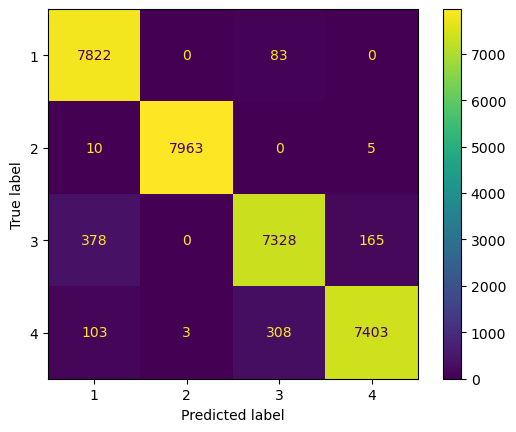

In [38]:
# Plotando a matriz de confusão usando o próprio Sklearn
grafico = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao,
                              display_labels=model.classes_)
grafico.plot()

plt.show()

#### 3.2.1. Erros de comissão e omissão

Por muito tempo eu fiz esses cálculos dos erros de comissão e omissão pelo Excel, então eu criei uma função aqui no Python para calcular esses erros de uma forma que facilite pra todo mundo e eu espero poder ajudar vocês com isso.

In [36]:
# Criando uma função que calcula os erros de comissão e omissão cuja entrada de dados é a matriz de confusão

def erros_comissao_omissao(conf):
    """
    Função de cálculo de erro de comissão e omissão
    Autoria: Sabrina Correa (paeslemesa@gmail.com)
    Criação: 29/04/2024

    Entrada:
    conf: matriz de confusão como array 2D

    Saída:
    Pandas DataFrame com os erros de comissão e omissão
    """
    n_classes = conf.shape[0]

    OE = []
    CE = []

    i= 0
    for i in range(n_classes):
        OE.append((np.sum(conf[i,:])-conf[i,i])/np.sum(conf[i,:]))
        CE.append((np.sum(conf[:,i])-conf[i,i])/np.sum(conf[:,i]))
    dict = {'class': range(1, n_classes +1), 'OE%': OE, 'CE%': CE}

    return pd.DataFrame(dict)


In [40]:
# Encontrando os valores em percentagem dos erros de comissão e omissão.
# Para transofrmar para acurácia do produtor/usuário, elas são 1-(erro de comissão/omissão)

erros = erros_comissao_omissao(matriz_confusao)
erros['OE%'] = erros['OE%']*100
erros['CE%'] = erros['CE%']*100

erros

,class,OE%,CE%
0,1,1.049968,5.906412
1,2,0.188017,0.037660
2,3,6.898742,5.065423
3,4,5.296149,2.244817


## 4. Classificando a imagem

Como estou classificando uma cena inteira do MSI/Sentinel-2 que é bem grandinho, precisei quebrar a imagem em pedaços menores. Esse processo eu fiz pelo QGIS que é mais fácil por lá. Quando for exportar um raster, selecione a opção VRT, como mostrado na figura abaixo.

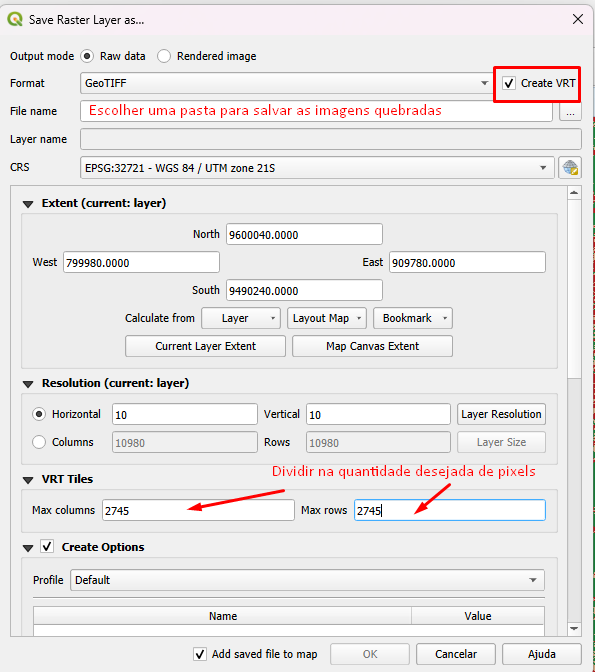


Agora, vou determianr aqui o nome da pasta onde estão as imagens e aonde eu quero salvar as imagens classificadas

In [52]:
# Na biblioteca Pathlib, quando usamos o "parent" queremos ir pro diretório exatamente acima do diretorio aonde estamos
pasta_imagens = Path(diretorio.parent, "01_Imagens/Sentinel2/Tiles")
caminho_saida = Path(diretorio.parent, "02_Classificacao_1")

Agora, vamos criar uma lista com todas as imagens que estão na pasta.

É sempre bom conferir que estamos no diretório certo e que o programa está realmente lendo os arquivos, então por mais simples que seja esse passo, recomendo que não pule ele.

In [54]:
img_lista = list(Path(pasta_imagens).glob("*.tif"))

# Printando os nomes dos arquivos encontrados
for arquivo in img_lista:
    print(arquivo.name)

Tiles.0.tif
Tiles.1.tif
Tiles.10.tif
Tiles.11.tif
Tiles.12.tif
Tiles.13.tif
Tiles.14.tif
Tiles.15.tif
Tiles.2.tif
Tiles.3.tif
Tiles.4.tif
Tiles.5.tif
Tiles.6.tif
Tiles.7.tif
Tiles.8.tif
Tiles.9.tif


Por fim, para classificarmos e salvarmos as imagens, vamos usar um comando FOR.

Não devemos nos esquecer que precisamos deixar nossos dados __exatamente na mesma ordem e escala do treinamento__, portanto, vamos dividir nossa imagem por 10000 e também calcular e adicionar a banda NDVI.

In [56]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
for imagem in img_lista: # criando um loop

    print(f"Trabalhando na imagem {imagem.name}...")
    #-----------------------------------------------------------------------------
    # Abrindo a imagem
    #-----------------------------------------------------------------------------
    with rasterio.open(imagem) as src: # abrindo a imagem
        img = src.read() #lendo as bandas da imagem
        profile = src.profile # pegando o perfil da imagem


    #-----------------------------------------------------------------------------
    # Ajustando a imagem para ficar igual aos dados de treinamento
    #-----------------------------------------------------------------------------
    img = img/10000 # dividindo por 10000 para normalizar os valores do MSI/Sentinel-2

    ndvi = (img[3] - img[2]) / (img[3] + img[2]) # calculando o NDVI

    img = np.concatenate((img, ndvi[np.newaxis, :, :]), axis=0) # concatenando o NDVI com as bandas RGB + NIR

    img2 = reshape_as_image(img) # transformando o raster (bandas, linhas, colunas) em imagem (linhas, colunas, bandas)
    X = np.reshape(img2, (img2.shape[0]*img2.shape[1], img2.shape[2])) # transformando a imagem em um array (número de pixels, bandas)

    #-----------------------------------------------------------------------------
    # Classificando a imagem
    #-----------------------------------------------------------------------------
    y_pred_img = model.predict(X) # predizendo a imagem

    y_final = y_pred_img.reshape(img[0].shape)[np.newaxis, :, :] # transformando o array de volta para o formato raster

    name_out = Path(caminho_saida, imagem.stem + "classificacao.tif") # nome do arquivo de saída


    #-----------------------------------------------------------------------------
    # Salvando a imagem classificada
    #-----------------------------------------------------------------------------

    # Alterando aqui os metadados da imagem
    profile.update(count = 1, # alterando a entrada dos números de bandas
                    dtype = 'uint8', # definindo o tipo de dado de saída e diminuindo o tamanho dele
                    compress = 'lzw', # comprimindo a imagem
                    nodata = 0 # valor de pixel sem informação
                    )

    # Salvando o arquivo
    with rasterio.open(name_out, 'w', **profile) as dst:
        dst.write(y_final.astype('uint8'))



Trabalhando na imagem Tiles.0.tif...
Trabalhando na imagem Tiles.1.tif...
Trabalhando na imagem Tiles.10.tif...
Trabalhando na imagem Tiles.11.tif...
Trabalhando na imagem Tiles.12.tif...
Trabalhando na imagem Tiles.13.tif...
Trabalhando na imagem Tiles.14.tif...
Trabalhando na imagem Tiles.15.tif...
Trabalhando na imagem Tiles.2.tif...
Trabalhando na imagem Tiles.3.tif...
Trabalhando na imagem Tiles.4.tif...
Trabalhando na imagem Tiles.5.tif...
Trabalhando na imagem Tiles.6.tif...
Trabalhando na imagem Tiles.7.tif...
Trabalhando na imagem Tiles.8.tif...
Trabalhando na imagem Tiles.9.tif...


### 4.1. Juntando as imagens numa só

É possível fazer isso via QGIS também, mas por aqui é bem facinho, vou mostrar.

In [59]:
# Gerando uma lista com as imagens classificadas
lista_imagens_classificadas = list(Path(caminho_saida).glob("Tiles*classificacao.tif"))

# Imprimindo a lista das imagens para conferir que está tudo certinho
for arquivo in lista_imagens_classificadas:

    print(arquivo.name)

Tiles.0classificacao.tif
Tiles.10classificacao.tif
Tiles.11classificacao.tif
Tiles.12classificacao.tif
Tiles.13classificacao.tif
Tiles.14classificacao.tif
Tiles.15classificacao.tif
Tiles.1classificacao.tif
Tiles.2classificacao.tif
Tiles.3classificacao.tif
Tiles.4classificacao.tif
Tiles.5classificacao.tif
Tiles.6classificacao.tif
Tiles.7classificacao.tif
Tiles.8classificacao.tif
Tiles.9classificacao.tif


In [60]:
# Aqui, vamos criar uma lista vazia para colocarmos os arquivos lidos
classificada_src = []

for file in lista_imagens_classificadas:
    classificada_src.append(rasterio.open(file)) # lendo os arquivos como objeto
    
mosaico, transformacao_saida = merge(classificada_src) # mosaicando as imagens

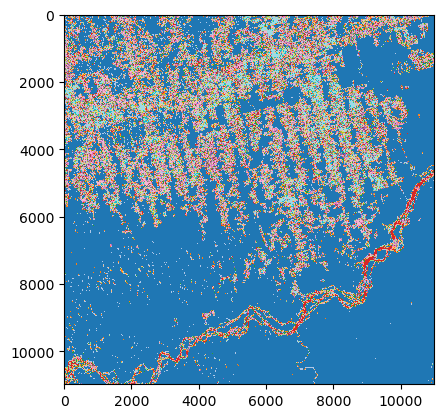

<Axes: >

In [61]:
# Agora para conferir se está tudo certinho, basta plotarmos o mosaico

show(mosaico, cmap='tab20')

#### 3.2. Salvando a imagem classificada

In [66]:

# Aqui estamos criando um perfil, que é um dicionário com os metadados da imagem
perfil = {
    "count":1, # numero de bandas
    "dtype": 'uint8', # tipo de dado
    "compress": 'lzw', # compressão
    "nodata": 0, # valor de pixel sem informação
    "transform": transformacao_saida, # transformação Afim de saída
    "height": mosaico.shape[1], # altura em pixels
    "width": mosaico.shape[2], # comprimento em pixels
    "crs": classificada_src[0].crs # sistema de coordenadas
}

perfil

{'count': 1,
 'dtype': 'uint8',
 'compress': 'lzw',
 'nodata': 0,
 'transform': Affine(10.0, 0.0, 799980.0,
        0.0, -10.0, 9600040.0),
 'height': 10980,
 'width': 10980,
 'crs': CRS.from_epsg(32721)}

In [67]:
imagem_saida = Path(caminho_saida, "mosaico_classificacao.tif") # nome do arquivo de saída
with rasterio.open(imagem_saida, "w", **perfil) as dst:
    dst.write(mosaico.astype('uint8')) # escrevendo a imagem
print("Imagem salva!")

Imagem salva!
